In [1]:
import os
import glob

import fiftyone as fo

from tator_tools.download_media import MediaDownloader
from tator_tools.fiftyone_clustering import FiftyOneDatasetViewer
from tator_tools.download_datasets import DatasetDownloader
from tator_tools.yolo_dataset import YOLODataset
from tator_tools.yolo_crop_regions import YOLORegionCropper
from tator_tools.train_model import ModelTrainer
from tator_tools.inference_video import VideoInferencer

from yolo_tiler import YoloTiler, TileConfig

# Download Media (video -> frames) from Tator

In [ ]:
# Initialize the downloader with the required parameters
downloader = MediaDownloader(
    api_token=os.getenv("TATOR_TOKEN"),
    project_id=155,
    output_dir="../Data"
)

# Download the media
media_ids = ["14759824"]

In [ ]:
downloader.download_data(media_ids,             # Download these videos
                         convert=False,         # Convert the videos to MP4
                         extract=True,          # Extract frames from the videos
                         every_n_seconds=3)     # Extract 1 frame every 3 seconds

In [ ]:
downloader.data

# View Clustered Frames from Tator using Fiftyone

In [ ]:
# Initialize the viewer with the path to the directory containing images
viewer = FiftyOneDatasetViewer(image_dir=downloader.image_dir)

# Process the dataset to create the FiftyOne dataset and generate the UMAP visualization
viewer.process_dataset()

In [ ]:
# Launch the FiftyOne app
try:
    session = fo.launch_app(viewer.dataset)
except:
    # Weird behavior in notebook
    session = fo.launch_app(viewer.dataset)

# Download Datasets from Tator

In [2]:
# Set parameters
api_token = os.getenv("TATOR_TOKEN")
project_id = 70  # 155

# Search string comes from Tator's Data Metadata Export utility
search_string = "eyJtZXRob2QiOiJBTkQiLCJvcGVyYXRpb25zIjpbeyJtZXRob2QiOiJPUiIsIm9wZXJhdGlvbnMiOlt7ImF0dHJpYnV0ZSI6IiR0eXBlIiwib3BlcmF0aW9uIjoiZXEiLCJpbnZlcnNlIjpmYWxzZSwidmFsdWUiOjUwMH1dfV19"

# Demo for downloading labeled data
frac = 1.0

dataset_name = "Marine_Debris"
output_dir = "../Data/Labeled_Data"

label_field = "MarineDebris"

In [3]:
# Create a downloader for the labeled data
downloader = DatasetDownloader(api_token,
                               project_id=project_id,
                               search_string=search_string,
                               frac=frac,
                               output_dir=output_dir,
                               dataset_name=dataset_name,
                               label_field=label_field)

NOTE: Authentication successful for jordan.pierce
NOTE: Search string saved to e:\tator-tools\Data\Labeled_Data\Marine_Debris\search_string.txt


In [4]:
# Download the labeled data
downloader.download_data()

NOTE: Querying Tator for labeled data
NOTE: Found 909 objects in query


Processing query: 100%|██████████| 909/909 [00:00<00:00, 27543.27it/s]


NOTE: Found 909 query objects after sampling
NOTE: Data saved to e:\tator-tools\Data\Labeled_Data\Marine_Debris\data.csv
NOTE: Data saved to e:\tator-tools\Data\Labeled_Data\Marine_Debris\data.json
NOTE: Downloading images to e:\tator-tools\Data\Labeled_Data\Marine_Debris\images


NOTE: Images downloaded to e:\tator-tools\Data\Labeled_Data\Marine_Debris\images


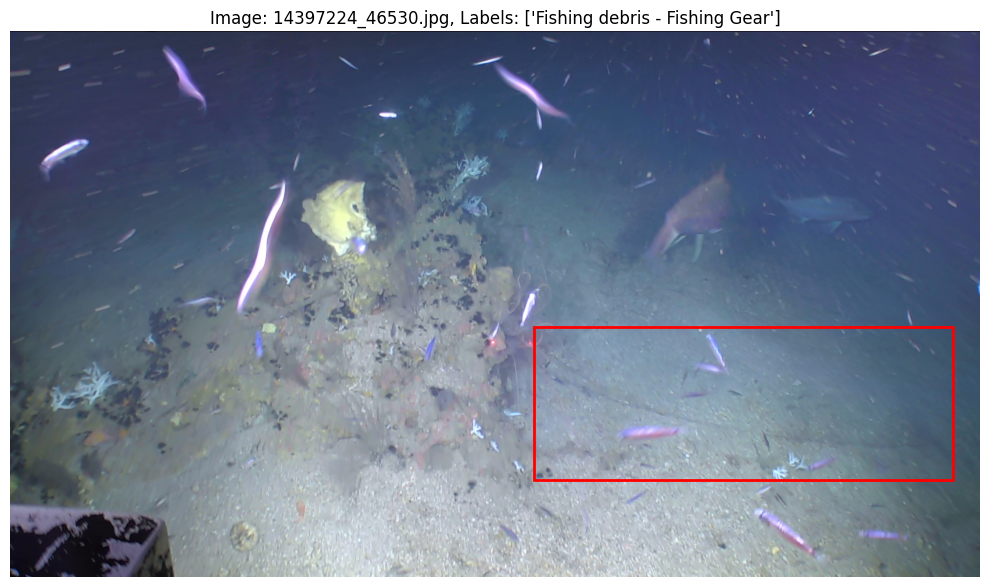

In [5]:
downloader.display_sample()

In [6]:
df = downloader.as_dataframe()  # .as_dict()

# Do some data exploration, filtering as needed
# Example: Drop all rows where x, y, width, or height is NaN
df = df.dropna(subset=["x", "y", "width", "height"])

df.head(3)

,media,frame,image_name,image_path,image_width,image_height,x,y,width,height,polygon,label
0,15171586,0,15171586_0.jpg,e:\tator-tools\Data\Labeled_Data\Marine_Debris...,None,None,0.706349,0.217207,0.161620,0.467515,[],Fishing debris - Monofilament Line
1,15171586,0,15171586_0.jpg,e:\tator-tools\Data\Labeled_Data\Marine_Debris...,None,None,0.334921,0.545839,0.304923,0.291661,[],Fishing debris - (Other) test
2,4156601,239265,4156601_239265.jpg,e:\tator-tools\Data\Labeled_Data\Marine_Debris...,None,None,0.319264,0.388462,0.332298,0.584687,[],"Human (Other) - plastic jug, rope"


# Convert Data into YOLO-formatted Dataset

In [7]:
# Set parameters
output_dir = "../Data/Labeled_Data/Marine_Debris"
dataset_name = "YOLO_Dataset"

train_ratio = 0.8
test_ratio = 0.1

task = 'detect' # 'detect' or 'segment'

In [8]:
# Create and process dataset
dataset = YOLODataset(
    data=df,
    output_dir=output_dir,
    dataset_name=dataset_name,
    train_ratio=train_ratio,
    test_ratio=test_ratio,
    task=task
)

In [9]:
# Process the dataset
dataset.process_dataset(move_images=False)  # Makes a copy of the images instead of moving them

Processing YOLO dataset with 372 annotations...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Dataset split: 255 train, 33 valid, 31 test images


Writing detection labels:   0%|          | 0/319 [00:00<?, ?it/s]

Copying images:   0%|          | 0/319 [00:00<?, ?it/s]

Dataset created at e:\tator-tools\Data\Labeled_Data\Marine_Debris\YOLO_Dataset
Classes: ['Fishing debris - Monofilament Line', 'Fishing debris - (Other) test', 'Human (Other) - plastic jug, rope', 'Line', 'Human (other) – tin can', 'Human (other) - string', 'Anchoring debris - Anchor', 'Fishing debris - Line', 'Human (other) - food carton', 'Oil & Gas - cable', 'Fishing debris - line', 'Fishing gear - line', 'Rope/Line', 'Anchoring debris - anchor', 'Anchoring debris - rope', 'Human debris - aluminum can', 'Maybe? Bottle?', 'Human debris - cable', 'Human debris - plastic', 'Fishing line', 'anchor?', 'anchor', 'beer bottle', 'rope?', 'rope', 'line', 'Anchoring debris or Fishing debris', 'Fishing debris or Anchoring debris', 'Fishing debris – monofilament line', 'Anchoring debris - Rope', '', 'Vessel - (Other) Test', 'Fishing debris - Trawling Gear', 'Oil & Gas - (Other) Metal barrel ring', 'Human (other) - (Other) Cable', 'Fishing debris - (Other) Line', 'Vessel - Firehose', 'Human (oth

Rendering Examples:   0%|          | 0/10 [00:00<?, ?it/s]

Rendered 10 examples to e:\tator-tools\Data\Labeled_Data\Marine_Debris\YOLO_Dataset\examples


In [10]:
dataset.dataset_dir

'e:\\tator-tools\\Data\\Labeled_Data\\Marine_Debris\\YOLO_Dataset'

# Tile Dataset (Optional)

In [13]:
src = dataset.dataset_dir               # Source YOLO dataset directory
dst = f"{dataset.dataset_dir}_Tiled"    # Output directory for tiled dataset

config = TileConfig(
    # Size of each tile (width, height). Can be:
    # - Single integer for square tiles: slice_wh=640
    # - Tuple for rectangular tiles: slice_wh=(640, 480)
    slice_wh=(1920, 1080),

    # Overlap between adjacent tiles. Can be:
    # - Single float (0-1) for uniform overlap percentage: overlap_wh=0.1
    # - Tuple of floats for different overlap in each dimension: overlap_wh=(0.1, 0.1)
    # - Single integer for pixel overlap: overlap_wh=64
    # - Tuple of integers for different pixel overlaps: overlap_wh=(64, 48)
    overlap_wh=(0.2, 0.2),

    # Input image file extension to process
    input_ext=".jpg",

    # Output image file extension to save (default: same as input_ext)
    output_ext=None,

    # Type of YOLO annotations to process:
    # - "object_detection": Standard YOLO format (class, x, y, width, height)
    # - "instance_segmentation": YOLO segmentation format (class, x1, y1, x2, y2, ...)
    annotation_type="object_detection",

    # Include negative samples (tiles without any instances)
    include_negative_samples=True
)

tiler = YoloTiler(
    source=src,
    target=dst,
    config=config,
    num_viz_samples=15,                     # Number of samples to visualize
    show_processing_status=True,            # Show the progress of the tiling process
)

In [ ]:
tiler.run()

# Crop Regions (Optional)

In [11]:
cropper = YOLORegionCropper(dataset_path=f"{dataset.dataset_dir}\\data.yaml", 
                            output_dir=f"{os.path.dirname(dataset.dataset_dir)}",
                            dataset_name="YOLO_Dataset_Cropped",
                            format_class_names=True)

In [12]:
# Process the dataset to create classification crops
cropper.process_dataset()

Added 316 images from train dataset
Added 86 images from validation dataset
Added 84 images from test dataset


SupervisionWarnings: Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.


NOTE: Loaded dataset - 577 detections found


Creating crops: 100%|██████████| 486/486 [00:04<00:00, 100.22it/s]


Created 577 crops from 486 images
Classification dataset YAML written to e:\tator-tools\Data\Labeled_Data\Marine_Debris/YOLO_Dataset_Cropped/data.yaml
Class distribution:
  Fishing debris - Monofilament Line: train=75, val=28, test=10
  Fishing debris - (Other) test: train=1, val=0, test=0
  Human (Other) - plastic jug, rope: train=2, val=0, test=1
  Line: train=6, val=1, test=0
  Human (other) – tin can: train=2, val=0, test=0
  Human (other) - string: train=1, val=2, test=0
  Anchoring debris - Anchor: train=3, val=0, test=1
  Fishing debris - Line: train=12, val=5, test=3
  Human (other) - food carton: train=2, val=0, test=0
  Oil & Gas - cable: train=10, val=2, test=2
  Fishing debris - line: train=12, val=5, test=3
  Fishing gear - line: train=2, val=0, test=0
  RopeLine: train=1, val=0, test=0
  Anchoring debris - anchor: train=3, val=0, test=1
  Anchoring debris - rope: train=33, val=4, test=9
  Human debris - aluminum can: train=4, val=1, test=0
  Maybe Bottle: train=2, val=1, 

# Train a YOLO Model

In [15]:
dir_ = "E:\\tator-tools\\Data\\Labeled_Data\\MR_Downward_Facing_Imagery\\YOLODataset_Detection"

# Initialize the trainer with the required parameters
trainer = ModelTrainer(
    training_data=f"{dir_}\\data.yaml",
    weights="yolov8m.pt",
    output_dir=f"{dir_}\\Training",
    name="yolov8m",
    task='detect',
    epochs=50,
    half=True,
    imgsz=640,
    single_cls=False,
    plots=True,
    batch=0.5,
)

In [ ]:
# Train the model
trainer.train_model()

In [ ]:
# Evaluate on the model (if test data is available)
trainer.evaluate_model()

# Inference on Video

In [19]:
# Set parameters
model_weights = "E:\\tator-tools\\Data\\Labeled_Data\\AUV_Polygons\\YOLODataset_Detection_Tiled\\Training\\AUV_Polygons_Detection\\weights\\best.pt"

video_path = "E:\\tator-tools\\Data\\Raw_Videos\\GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH_converted.mp4"
output_dir = "E:\\tator-tools\\Data\\Inference_Results"


In [ ]:
inferencer = VideoInferencer(
    weights_path=model_weights,
    model_type='yolo',
    video_path=video_path,
    output_dir=output_dir,
    start_at=1000,
    end_at=2000,
    conf=0.5,
    iou=0.3,
    track=False,
    segment=False,
    sahi=False,
    show=True
)

In [ ]:
inferencer.inference()